# Hubel & Wiesel: bar of light

In this notebook, we reproduce the [classic Hubel & Wiesel bar of light experiment](https://www.youtube.com/watch?v=OGxVfKJqX5E) using an iP-VAE model neuron. 

In [1]:
# HIDE CODE


import os, sys
sys.path.insert(0, './')
from utils.plotting import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


import soundfile as sf
from skimage import transform
from matplotlib import patheffects as mpl_patheffects
from matplotlib.animation import FuncAnimation, FFMpegWriter


def moving_bar(px, angle_deg, thickness_ratio, n_frames, n_zero_frames=1):
    θ = np.deg2rad(angle_deg)
    w = thickness_ratio * px                      # bar thickness in pixels
    yy, xx = np.mgrid[:px, :px] - px / 2 + 0.5    # centered pixel grid

    # Coordinate perpendicular to the bar
    y_perpend = -xx * np.sin(θ) + yy * np.cos(θ)

    # Start just outside one side, end outside the other
    span = px / 2 + w / 2 + w
    centers = np.linspace(-span, span, n_frames)

    # Allocate movie with leading blank frames
    movie = np.zeros((n_zero_frames + n_frames, px, px), np.uint8)

    # Draw the bar starting after the blank segment
    for t, c in enumerate(centers):
        mask = np.abs(y_perpend - c) <= w / 2
        movie[n_zero_frames + t] = mask.astype(np.uint8)
    return movie


def spike_counts_to_audio(
        spike_counts,
        sample_rate=44_100,     # Hz
        bin_dur_ms=5.0,         # ms per time-bin in “real” time
        speed_factor=1.0,       # <1.0 = slower, >1.0 = faster
        pop_freq=1000.0,        # Hz tone at pop onset (optional)
        pop_dur_ms=1.0,         # ms of each pop click
        gain=0.6,               # overall loudness (0-1)
        envelope='exp'          # 'exp' or 'rect'
    ):
    """
    Convert a 1-D array of integer spike counts into an audio waveform.

    Parameters
    ----------
    spike_counts : 1-D array-like of ints
        Number of spikes in each time bin.
    sample_rate : int
        Samples per second in the output waveform.
    bin_dur_ms : float
        Duration of each input bin before speed-up/down.
    speed_factor : float
        Multiply all bin durations by this factor (e.g. 0.5 doubles speed).
    pop_freq : float
        Sine frequency for each pop (set None for impulses).
    pop_dur_ms : float
        Duration of each pop (before speed factor).
    gain : float
        Scales the final waveform (0–1 avoids clipping).
    envelope : str
        'exp' gives a decaying exponential click, 'rect' is square.
    """
    spike_counts = np.asarray(spike_counts, dtype=int)
    # Effective durations after time-stretch/compress
    bin_samples = int(round((bin_dur_ms * 1e-3) * sample_rate / speed_factor))
    pop_samples = int(round((pop_dur_ms * 1e-3) * sample_rate / speed_factor))

    # Pre-compute a single pop waveform
    t = np.arange(pop_samples) / sample_rate
    if pop_freq is None:
        pop = np.zeros(pop_samples); pop[0] = 1.0   # impulse
    else:
        pop = np.sin(2 * np.pi * pop_freq * t)
    if envelope == 'exp':
        pop *= np.exp(-5 * t / (pop_dur_ms * 1e-3))  # fast decay
    pop /= np.abs(pop).max()                         # normalize

    # Allocate output
    total_samples = bin_samples * len(spike_counts)
    audio = np.zeros(total_samples, dtype=np.float32)

    rng = np.random.default_rng()
    for i, n_spikes in enumerate(spike_counts):
        if n_spikes <= 0:
            continue
        start = i * bin_samples
        # Randomly place n_spikes pops inside this bin
        offsets = rng.integers(0, bin_samples - pop_samples, size=n_spikes)
        for o in offsets:
            idx = start + o
            audio[idx:idx + pop_samples] += pop

    # Linear relationship: amplitude ∝ spike count (already additive)
    # Normalize and apply overall gain
    audio *= gain / max(np.abs(audio).max(), 1e-9)

    return audio


def save_waveform(waveform, filename, sample_rate=44_100):
    sf.write(filename, waveform, sample_rate, subtype='PCM_16')


def main_subplot(ax, lamb, spikes, t=None):
    assert len(lamb) == len(spikes)
    if t is None:
        t = len(lamb)
    # plot: firing rates
    ax.plot(
        lamb[:t],
        color='red',
        lw=4,
        alpha=0.8,
        label='firing rate',
    )
    # plot: spikes
    markerline, stemlines, _ = ax.stem(
        range(t), spikes[:t],
        linefmt='-',
        markerfmt='.',
        basefmt=' ',
        label='spikes',
    )
    # Color the pieces separately
    plt.setp(stemlines, color="dimgrey", lw=0.8)
    plt.setp(
        markerline,
        markerfacecolor="cyan",
        markeredgecolor="k",
        markersize=11,
    )
    add_legend(ax, fontsize=14)
    ax.locator_params(axis='y', nbins=int(max(spikes) * 1.2))
    ax.grid(axis='y')
    ax.set_xlabel('Time index (arbitrary units)', color='dimgrey', fontsize=14)

    xticks = [i for i in range(len(lamb)) if i % 10 == 0]
    ax.set(
        xticks=xticks,
        xticklabels=xticks,
        ylim=(-0.55, 11.55),
        xlim=(-3.4, 71.4),
    )

    # text: spikes
    txt = ax.text(
        -0.08, 0.50, "Sampled spike counts",          # x, y in Axes coords
        color="cyan",
        rotation="vertical",
        va="center", ha="center",
        fontsize=14, weight="bold",
        transform=ax.transAxes,
    )
    # add a dimgrey outline
    txt.set_path_effects([
        mpl_patheffects.Stroke(linewidth=2.0, foreground="dimgrey"),
        mpl_patheffects.Normal(),
    ])
    
    # text: firing rates
    ax.text(
        -0.14, 0.50, "Firing rate [spikes / sec]",
        color="red",
        rotation="vertical",
        va="center", ha="center",
        fontsize=16, weight="bold",
        transform=ax.transAxes,
    )
    return ax


def save_animation(save_file):
    # ------------- 1. Create figure and axes that never change -------------
    fig = plt.figure(figsize=(9, 6.5), dpi=100)
    
    gs = matplotlib.gridspec.GridSpec(
        nrows=3,
        ncols=5,
        width_ratios=[1, 1, 1, 0.1, 1],
    )
    
    ax_main    = fig.add_subplot(gs[:, :3])
    ax_rf      = fig.add_subplot(gs[0, -1])
    ax_overlay = fig.add_subplot(gs[1, -1])
    ax_bar     = fig.add_subplot(gs[2, -1])
    
    remove_ticks(ax_rf,      False)
    remove_ticks(ax_overlay, False)
    remove_ticks(ax_bar,     False)
    
    ax_rf.set_ylabel('\n'.join(['Model "neuron"', 'receptive field (RF)']),
                     color='dimgrey', fontsize=13)
    ax_overlay.set_ylabel('\n'.join(['Stimulus / RF', '(overlaid)']),
                          color='dimgrey', fontsize=13)
    ax_bar.set_ylabel('\n'.join(['Moving bar', 'stimulus']),
                      color='dimgrey', fontsize=13)
    
    # Static RF images
    ax_rf.imshow(w_upsampled, cmap='Greys_r')               # RF panel at top right
    ax_overlay.imshow(w_upsampled, cmap='Greys_r')          # RF background for overlay panel
    
    # Placeholders for changing data
    img_overlay = ax_overlay.imshow(
        np.full_like(w_upsampled, np.nan),                  # start fully transparent
        cmap='bwr', vmin=-1, vmax=1, alpha=0.3
    )
    img_bar = ax_bar.imshow(
        np.zeros_like(w_upsampled),
        cmap='Greys_r', vmin=-1, vmax=1
    )
    
    # Draw the first version of the main subplot so the axis limits are set
    main_subplot(ax_main, lamb, spikes, t=1)  # adjust if indexing starts at 0
    
    # ------------- 2. Define frame update function -------------
    def update(t):
        # Main panel: clear and redraw
        ax_main.clear()
        main_subplot(ax_main, lamb, spikes, t=t)
    
        # Build stimulus and overlay matrices
        stim = frames2p[t].astype(float)
        img_bar.set_data(stim)
    
        overlay = stim.copy()
        overlay[overlay == 0] = np.nan                       # keep zeros invisible
        img_overlay.set_data(overlay)
    
        # Return artists that changed (for blitting)
        return img_bar, img_overlay
    
    # ------------- 3. Create and save animation -------------
    frame_idx = range(1, 70)                                 # 1 to 69 inclusive
    ani = FuncAnimation(
        fig, update,
        frames=frame_idx,
        blit=False,             # set True if update returns every changed artist
        interval=100            # milliseconds per frame (10 fps)
    )
    writer = FFMpegWriter(fps=12, bitrate=8000)
    ani.save(save_file, writer=writer, dpi=900)

In [3]:
from utils.animation import show_movie


device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [4]:
save_dir = './media'
os.makedirs(save_dir, exist_ok=True)
print(sorted(os.listdir(save_dir)))

['model_tree.png']

## Load

In [5]:
from base.utils_model import load_model_lite

fit = 'poisson_<grad|lin>_vH16-wht_t-16_b-24_k-[512]'
tr, meta = load_model_lite(pjoin('./checkpoints', fit), device=device)

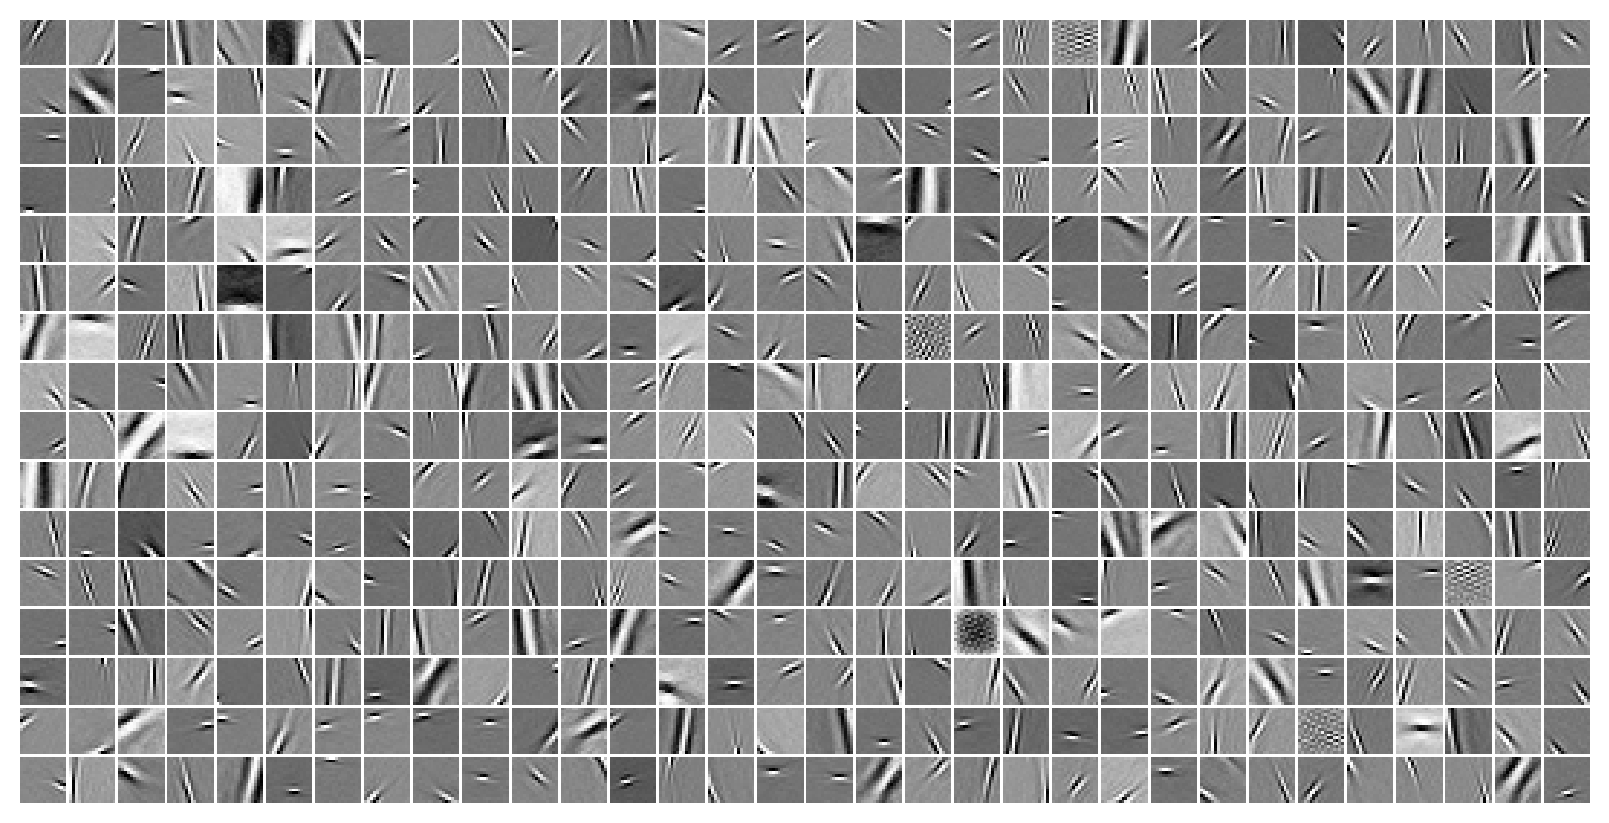

In [6]:
tr.model.show();

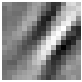

In [7]:
neuron_i = 497
tr.model.show(order=[neuron_i], nrows=1, dpi=20);

In [8]:
w = tonp(tr.model.layer.get_weight()).T
w = w[neuron_i].reshape(16, 16)

w_upsampled = transform.resize(
    image=w,
    output_shape=(128, 128),
    anti_aliasing=True,
    mode='reflect',
)
w.shape, w_upsampled.shape

((16, 16), (128, 128))

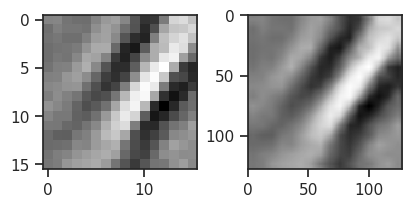

In [9]:
fig, axes = create_figure(1, 2, (4, 2))
axes[0].imshow(w, cmap='Greys_r')
axes[1].imshow(w_upsampled, cmap='Greys_r')
plt.show()

Upsampled for visualization purposes only

## Moving bar stimulus

In [10]:
%%time


kws = dict(
    n_frames=400,
    n_zero_frames=300,
    thickness_ratio=0.2,
)

frames = []
frames_highres = []
for theta in range(360):
    frames.append(moving_bar(px=16, angle_deg=theta, **kws))
    frames_highres.append(moving_bar(px=128, angle_deg=theta, **kws))

frames_highres = np.stack(frames_highres)
frames = tr.to(np.stack(frames))
frames.shape, frames_highres.shape

CPU times: user 9.95 s, sys: 2.99 s, total: 12.9 s
Wall time: 5.18 s


(torch.Size([360, 700, 16, 16]), (360, 700, 128, 128))

In [11]:
%%time


seed = 42
tr.model.cfg.set_seeds(seed)
tr.model.reset_inference_state(len(frames))

shape = tuple(frames.shape[:2])
r2 = np.zeros(shape)
mse = np.zeros(shape)
samples = np.zeros((*shape, 512))
firing_rates = np.zeros((*shape, 512))

for t in range(frames.shape[1]):
    tr.model.update_time(t)
    output = tr.model.xtract_ftr(
        frames[:, t].flatten(start_dim=1),
        return_extras=['r2', 'mse', 'samples', 'u'],
    )
    r2[:, t] = tonp(output['r2'])
    mse[:, t] = tonp(output['mse'])
    samples[:, t, :] = tonp(output['samples'])
    firing_rates[:, t, :] = tonp(output['u'].exp())

CPU times: user 8.55 s, sys: 693 ms, total: 9.24 s
Wall time: 3.33 s


In [12]:
orientation_i = 125  # angle (degrees)

In [13]:
intvl = range(465, 535)
spikes = samples[orientation_i, :, neuron_i][intvl]
lamb = firing_rates[orientation_i, :, neuron_i][intvl]

delay = 15
intvl_delay = range(intvl.start - delay, intvl.stop - delay)
frames2p = tonp(frames_highres[orientation_i])[intvl_delay]

In [14]:
audio = spike_counts_to_audio(
    spikes[1:],
    sample_rate=48_000,
    bin_dur_ms=70.0,
    speed_factor=0.845,   # play X % slower than real time
    pop_freq=500,
    pop_dur_ms=2.5,
    gain=0.8,
)
file = pjoin(save_dir, f'neuron-{neuron_i}_spiking_audio.wav')
save_waveform(audio, file, sample_rate=48_000)

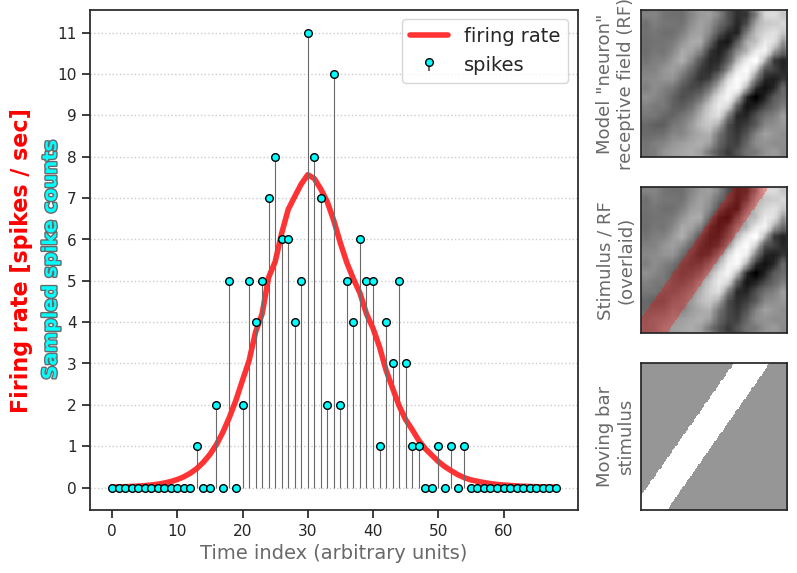

In [15]:
fig = plt.figure(figsize=(9, 6.5), dpi=100)

gs = matplotlib.gridspec.GridSpec(
    nrows=3,
    ncols=5,
    width_ratios=[1, 1, 1, 0.1, 1],
)
ax_main = fig.add_subplot(gs[:, :3])
ax_rf = fig.add_subplot(gs[0, -1])
ax_overlay = fig.add_subplot(gs[1, -1])
ax_bar = fig.add_subplot(gs[2, -1])

remove_ticks(ax_rf, False)
remove_ticks(ax_overlay, False)
remove_ticks(ax_bar, False)

ax_rf.set_ylabel('\n'.join(['Model "neuron"', 'receptive field (RF)']), color='dimgrey', fontsize=13)
ax_overlay.set_ylabel('\n'.join(['Stimulus / RF', '(overlaid)']), color='dimgrey', fontsize=13)
ax_bar.set_ylabel('\n'.join(['Moving bar', 'stimulus']), color='dimgrey', fontsize=13)

t = 69

ax_main = main_subplot(ax_main, lamb, spikes, t=t)
ax_rf.imshow(w_upsampled, cmap='Greys_r')
ax_overlay.imshow(w_upsampled, cmap='Greys_r')

stimulus = frames2p[t].astype(float)
ax_bar.imshow(stimulus, cmap='Greys_r', vmin=-1, vmax=1)

overlay = stimulus.copy()
overlay[overlay == 0] = np.nan
ax_overlay.imshow(overlay, cmap='bwr', vmin=-1, vmax=1, alpha=0.3);

In [16]:
show_movie(frames2p, vmin=-1.0, vmax=1.0)

## save animation

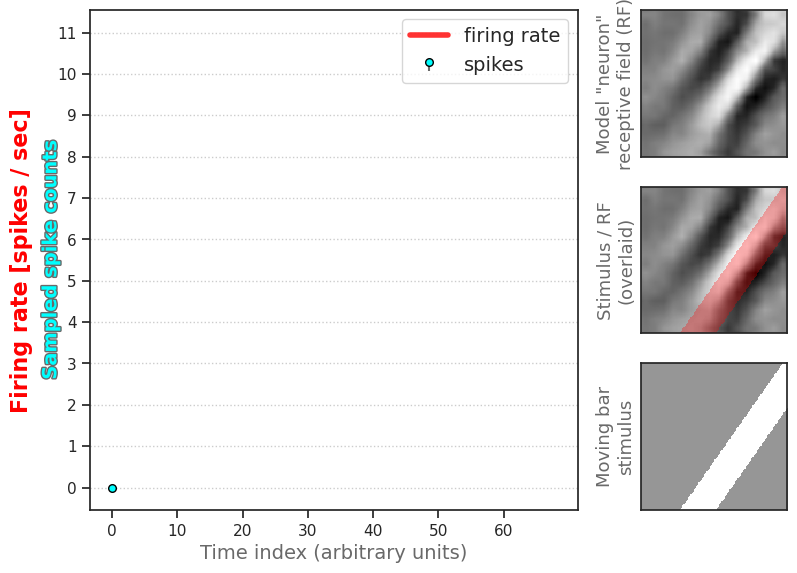

In [17]:
file_name = f"neuorn-{neuron_i}_movie.mp4"
save_animation(pjoin(save_dir, file_name))